In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

def plot_scatter_func(x, y, label, title, xlab, ylab, x1 = None, x2 = None, y1 = None, y2 = None):

    f, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y, label = label)
    ax.set_title(title, fontsize = 30)
    ax.set_xlabel(xlab, fontsize = 30)
    ax.set_ylabel(ylab, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.legend(loc = 'best', fontsize = 20)
    ax.grid(True)

    return f

def phase_func(Y):
    phases = np.angle(Y) * 180 / np.pi
    
    return phases

#dBu = 20log10(V/0.775V)

#Why the windowing? The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rfft(y, cnv): #this function computes the fft of y
    #window = get_window("hanning", len(y))
    #window = 1
    #y_windowed = y * window
    if np.isnan(y).any():
        nan_indices = np.where(np.isin(y))[0]
        print(f"Input data contains NaN values in {nan_indices}.")
        
    if np.isinf(y).any():
        print("Input data contains Inf values.")
        
    N = len(y)
    print(f"y_windowed: {y}")
    Y = fft.rfft(y)
    print(f"Y: {Y}")
    phases = phase_func(Y)
    print(phases)
    Y_normalized = np.abs(Y) / N
    #Y_dBu = 20*(np.log10(np.abs(Y_normalized)  * cnv / 0.775 ))
    Y_dBu = np.abs(Y)    
    return Y_dBu, phases

In [2]:
hour = '15.42'
day = '08082024'

# Method A: Phases of the average of the waveforms

### compute and plot the average of the waveforms

In [3]:
file_pattern = f"../../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list_A = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_A = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #The argument errors='coerce' specifies that any non-numeric values encountered during the conversion should be replaced with NaN (Not a Number)
        amplitudes_A = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        if np.isnan(amplitudes_A).any():
            nan_indices = np.where(np.isnan(amplitudes_A))[0]
            print(f"Input data contains NaN values in {nan_indices} at {i} file.")
            #amplitudes_A[nan_indices] = 0
 
        amplitudes_list_A.append(amplitudes_A)

all_amplitudes_A = np.stack(amplitudes_list_A, axis = 0)
print(all_amplitudes_A)

No files found for the given pattern.


ValueError: need at least one array to stack

In [35]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

avg_wf = np.mean(all_amplitudes_A, axis=0)

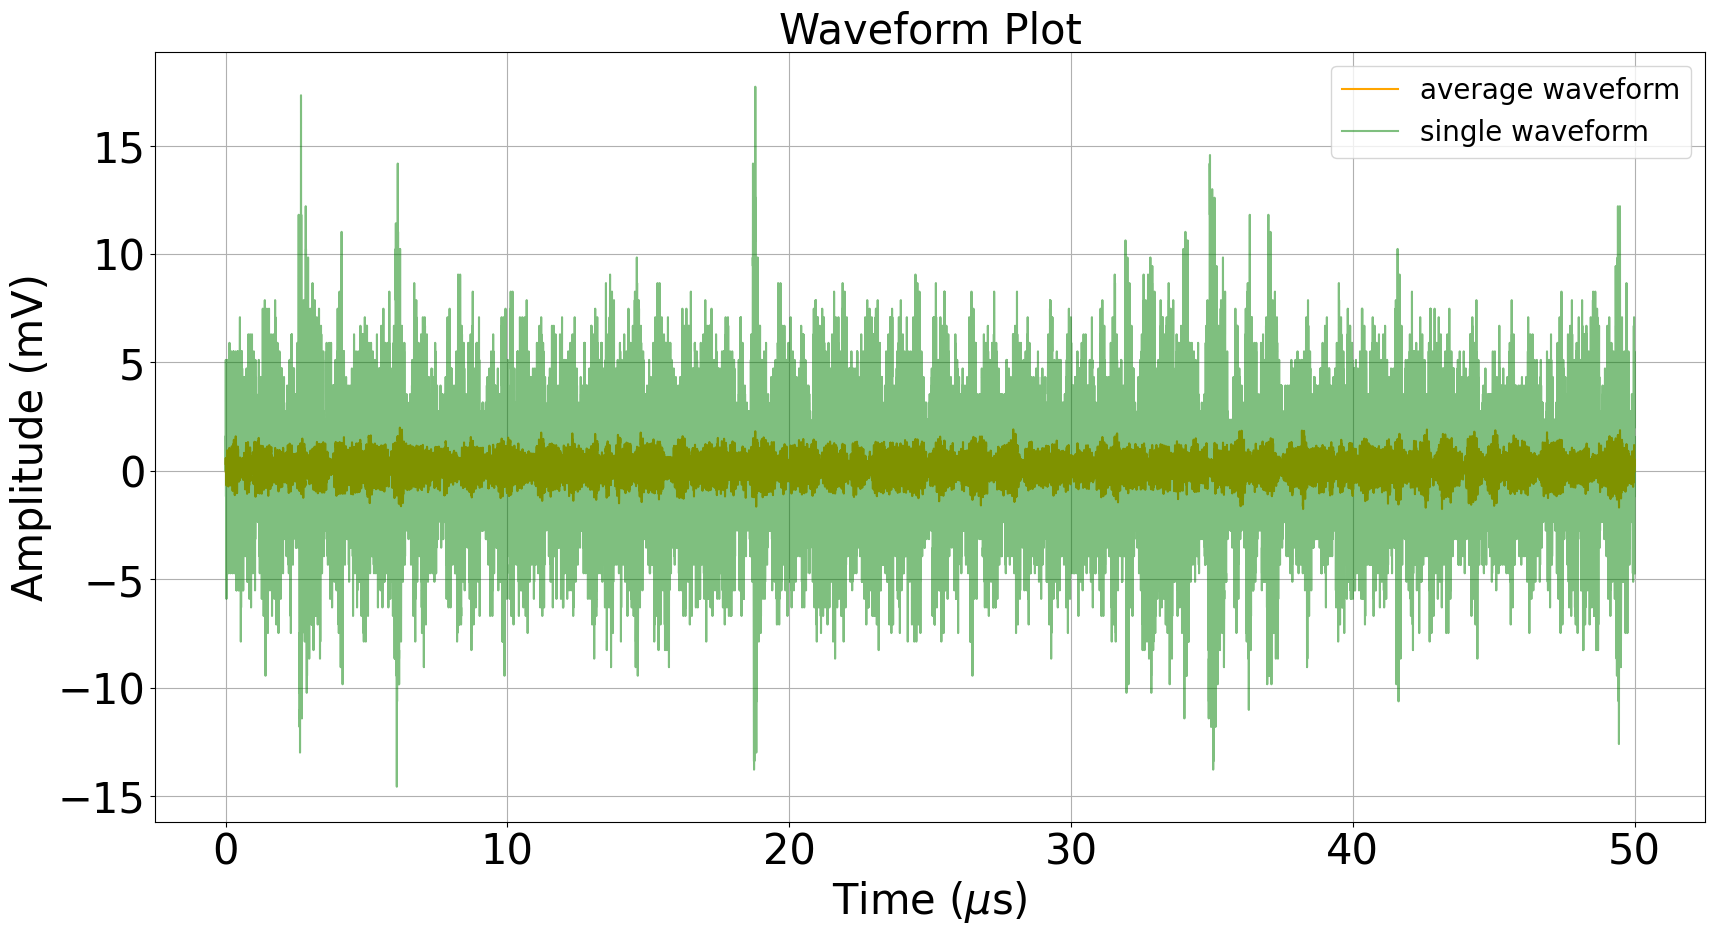

In [36]:
plt.figure(figsize=(20, 10))
#plt.errorbar(times_A, A, yerr=stds_wf, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1, label = f"{hour}_{day}")
plt.plot(times_A, avg_wf, color = 'orange', label = 'average waveform')

plt.plot(times_A, all_amplitudes_A[1, :], alpha = 0.5, color = 'green', label = 'single waveform')

plt.title('Waveform Plot', fontsize = 30)
plt.xlabel(r'Time ($\mu$s)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude (mV)', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc = "best",  prop={'size': 20})
plt.grid(True)
plt.show()

### compute and plot the phases of the average waveform

f_s_A = [1250.01998229]
y_windowed: [ 0.32603345  0.43676177  0.4552165  ...  0.09227354  0.00615151
 -0.02460637]
Y: [8.56275769e+03 +0.j         5.60164345e+01+19.59422438j
 4.02492980e+01 -3.7625003j  ... 7.11223984e+00 -1.85065278j
 6.71428123e-01 -5.82126486j 5.72834602e+01 +0.j        ]
[  0.          19.27954133  -5.34048383 ... -14.58531117 -83.42054469
   0.        ]
y_windowed: [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
Y: [8355.1174274   +0.j           62.56883215+104.66548377j
  151.96558748 +76.6255814j  ...  -21.19268503  -9.11529271j
  -17.36351856 +21.43656347j  108.6613652   +0.j        ]
[   0.           59.12909604   26.7586038  ... -156.72673235  129.00731463
    0.        ]
[8.56275769e+03 5.93445412e+01 4.04247746e+01 ... 7.34907282e+00
 5.85985839e+00 5.72834602e+01]


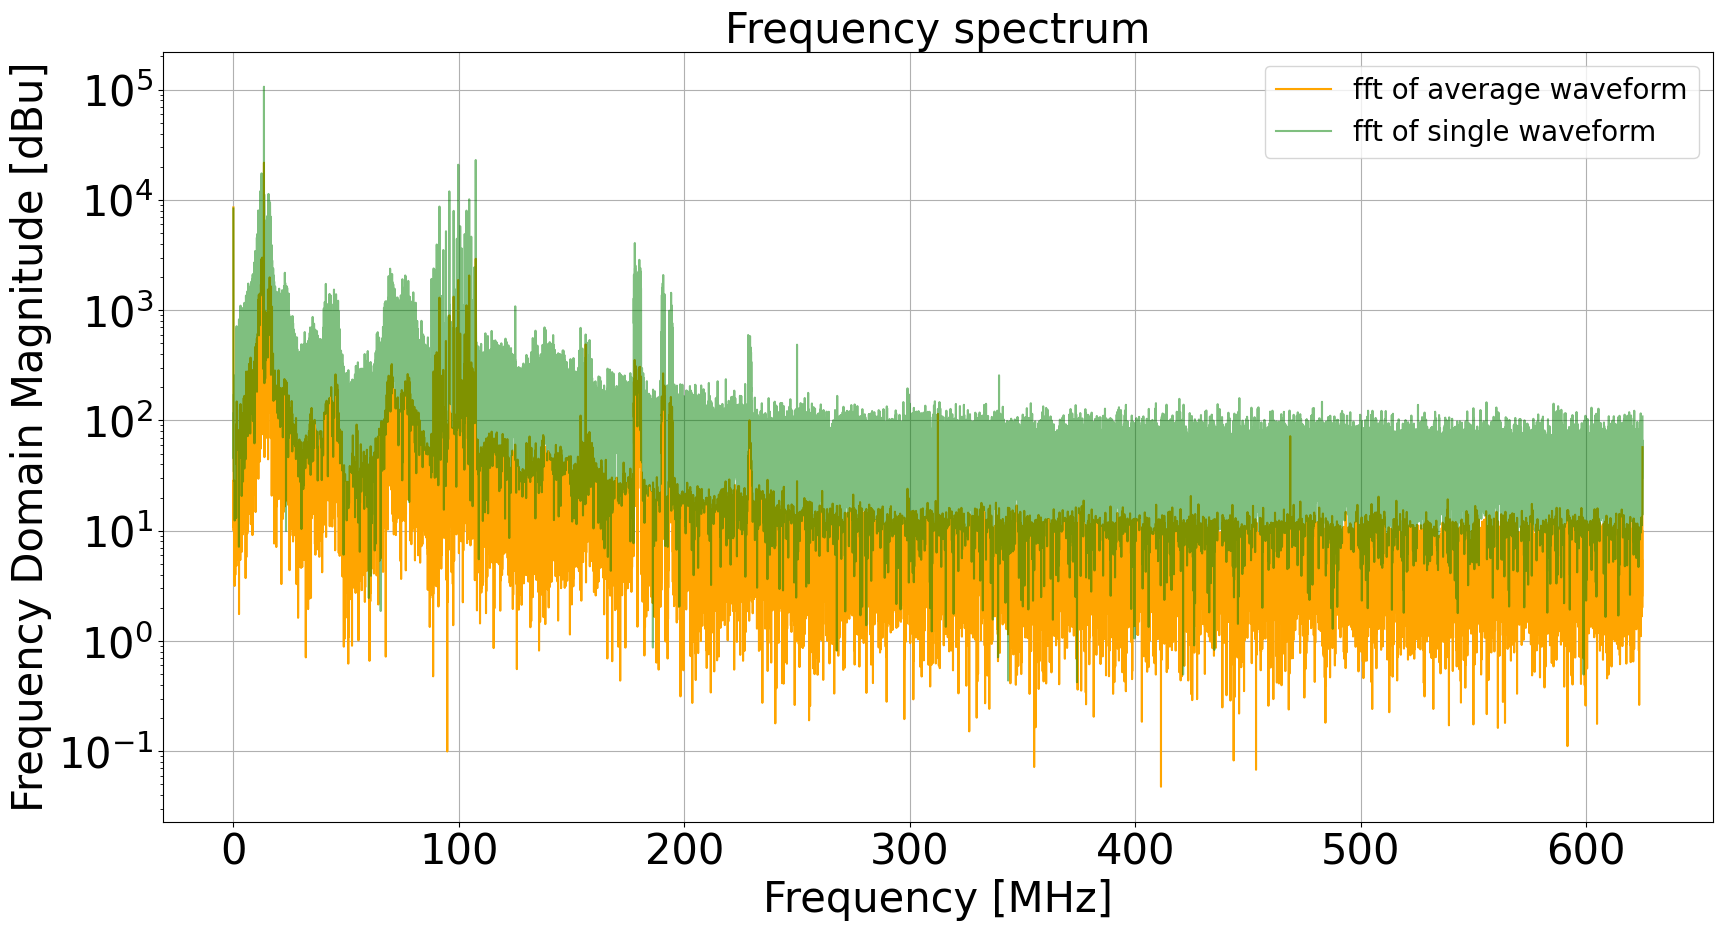

Execution time: 1.1956117153167725 seconds


In [37]:
span_A = times_A[-1:]
f_s_A = len(times_A) / span_A
print(f"f_s_A = {f_s_A}")
freqs_A = fft.rfftfreq(len(avg_wf), 1/f_s_A) #window lenght, sample spacing

#plot the fft and see how much time it takes
start_time = time.time()

Y_dBu_A, phases_A = rfft(avg_wf, conversion_factor)
Y_dBu_single_wf_A, phases_single_wf_A = rfft(all_amplitudes_A[1, :], conversion_factor)

plt.figure(figsize = (20, 10))
#plt.errorbar(freqs_A, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
print(Y_dBu_A) #NAN
plt.plot(freqs_A, Y_dBu_A, color = 'orange', label = 'fft of average waveform')
plt.plot(freqs_A, Y_dBu_single_wf_A, alpha = 0.5, color = 'green', label = 'fft of single waveform')

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()
plt.legend(fontsize = 20)
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [50]:
Y_dBu_A_log = np.log(Y_dBu_A)
Y_dBu_single_wf_A_log = np.log(Y_dBu_single_wf_A)

offset_blue = np.mean(Y_dBu_A_log[(freqs_A >= 250) & (freqs_A <= 350)])
offset_orange = np.mean(Y_dBu_single_wf_A_log[(freqs_A >= 250) & (freqs_A <= 350)])
print(f"offset blue: {offset_blue} - offset orange: {offset_orange} = {offset_blue - offset_orange}")
diff = offset_blue - offset_orange

offset blue: 1.6910403497866486 - offset orange: 3.763240445529131 = -2.0722000957424824


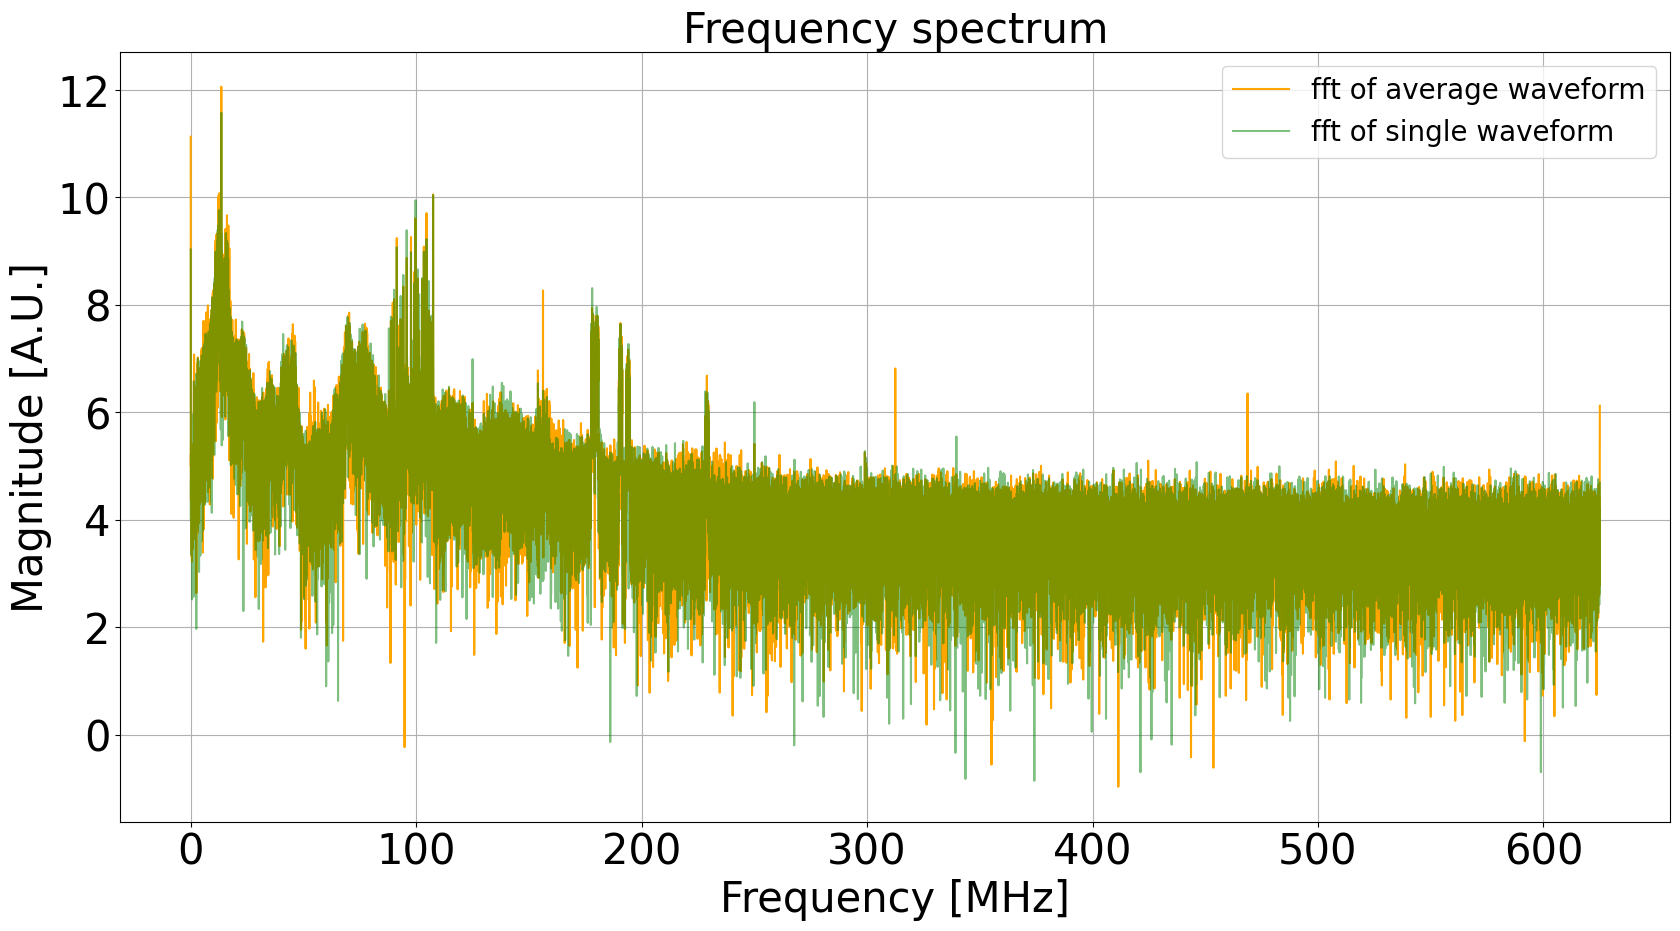

Execution time: 1367.9859309196472 seconds


In [55]:
plt.figure(figsize = (20, 10))
#plt.errorbar(freqs_A, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_A, Y_dBu_A_log - diff, color = 'orange', label = 'fft of average waveform')
plt.plot(freqs_A, Y_dBu_single_wf_A_log, alpha = 0.5, color = 'green', label = 'fft of single waveform')

plt.title(' ', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('log(Magnitude) [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)
plt.show()


end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

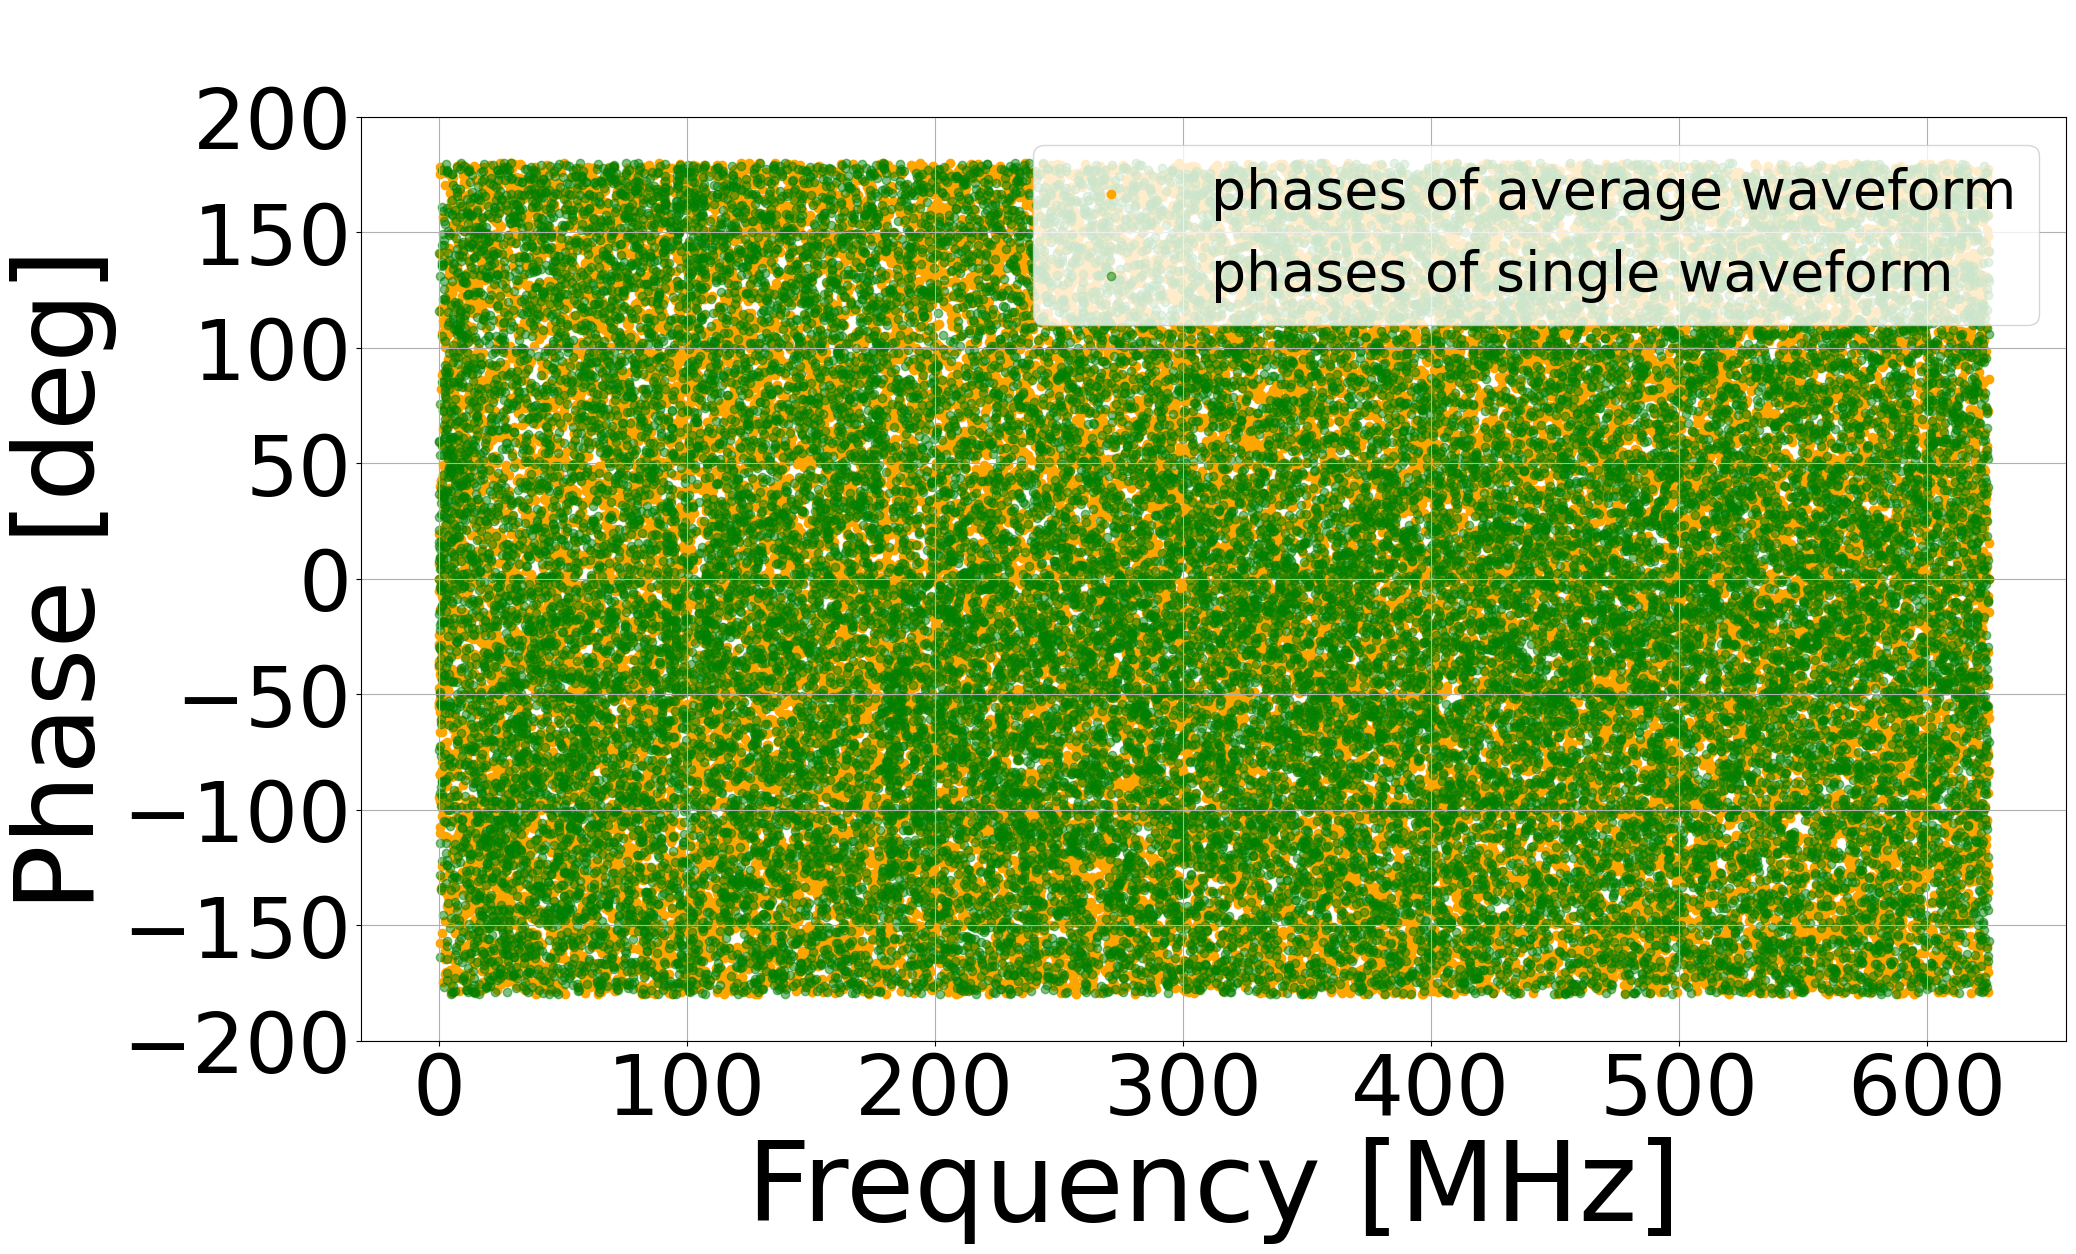

In [67]:
plt.figure(figsize = (22, 12))
plt.scatter(freqs_A, phases_A, color = 'orange', label = 'phases of average waveform')
plt.scatter(freqs_A, phases_single_wf_A,  alpha = 0.5, color = 'green', label = 'phases of single waveform')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.yticks(fontsize = 60)
plt.legend(loc = 'best', fontsize = 40)
plt.grid(True)
plt.ylim(-200, 200)

#plt.savefig("080824_15.24/phase_of_avg_fft.png", format = "png", bbox_inches="tight")
plt.savefig("../../Results/080824_15.42/MethodA_phases.pdf", format = "pdf", bbox_inches="tight")

plt.show()

# Method B: Average of the phases of the ffts

In [41]:
file_pattern_wfs = f"../../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list_B = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list_wfs):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_B = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes_B = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_B.append(amplitudes_B)
            
all_amplitudes_B = np.stack(amplitudes_list_B, axis = 0)
print(all_amplitudes_B)


0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
[[-1.968504  -1.574803  -1.181102  ... -0.3937007 -1.181102  -1.181102 ]
 [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
 [-0.3937007 -0.3937007  0.3937007 ... -0.7874015 -2.362205  -3.149606 ]
 ...
 [-3.149606  -2.755905  -1.181102  ...  3.149606   3.149606   2.755905 ]
 [ 1.574803   1.574803   1.574803  ...  3.149606   3.149606   1.574803 ]
 [ 1.181102   1.574803   2.755905  ...  2.755905   1.968504   2.362205 ]]


In [42]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

### compute the FFTs

In [43]:
Ys_dBu_list = []
phases_list = []

for i in range(all_amplitudes_B.shape[0]):
    Y_dBu_B, phase_B = rfft(all_amplitudes_B[i, :], conversion_factor)
    Ys_dBu_list.append(Y_dBu_B)
    phases_list.append(phase_B)

Ys_dBu_B = np.stack(Ys_dBu_list, axis = 0)
phases_B = np.stack(phases_list, axis = 0)
print(f"Ys_dBu_B: {Ys_dBu_B}")
print(f"phases_B: {phases_B}")

y_windowed: [-1.968504  -1.574803  -1.181102  ... -0.3937007 -1.181102  -1.181102 ]
Y: [ 8.20944824e+03 +0.j          4.32860718e+01+25.58407797j
 -2.52023795e+01-87.86470264j ...  3.12530404e+01+11.87688546j
 -9.26031211e+00 +4.91577893j  6.29909240e+00 +0.j        ]
[   0.           30.58505873 -106.00456808 ...   20.80796059  152.0386812
    0.        ]
y_windowed: [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
Y: [8355.1174274   +0.j           62.56883215+104.66548377j
  151.96558748 +76.6255814j  ...  -21.19268503  -9.11529271j
  -17.36351856 +21.43656347j  108.6613652   +0.j        ]
[   0.           59.12909604   26.7586038  ... -156.72673235  129.00731463
    0.        ]
y_windowed: [-0.3937007 -0.3937007  0.3937007 ... -0.7874015 -2.362205  -3.149606 ]
Y: [8648.4244852   +0.j           87.41341128 +26.62197319j
   54.19701797 -58.71138386j ...   24.34862928 -25.17201398j
   31.75589297-124.66315951j   27.9527228   +0.j        ]
[  0.          16.938245

### compute and plot the average fft and the average of their phases

In [44]:
span_B = times_B[len(times_B)-1] 
f_s_avg_fft = len(times_B) / span_B
print(f"f_s_avg_fft = {f_s_avg_fft}")
freqs_B = fft.rfftfreq(all_amplitudes_B.shape[1], 1/f_s_avg_fft) #window lenght, sample spacing

avg_fft_dBu_B = np.mean(Ys_dBu_B, axis = 0)
avg_phases_B = np.mean(phases_B, axis = 0)
print(f"avg_fft_dBu_B: {avg_fft_dBu_B}")
print(f"avg_phases_B: {avg_phases_B}")


f_s_avg_fft = 1250.0199822905822
avg_fft_dBu_B: [8562.75769291  119.37760201   96.86667995 ...   46.67938116   44.17882861
   60.8882722 ]
avg_phases_B: [  0.          12.04390863  -2.41214908 ...   0.02600033 -11.75326485
  16.875     ]


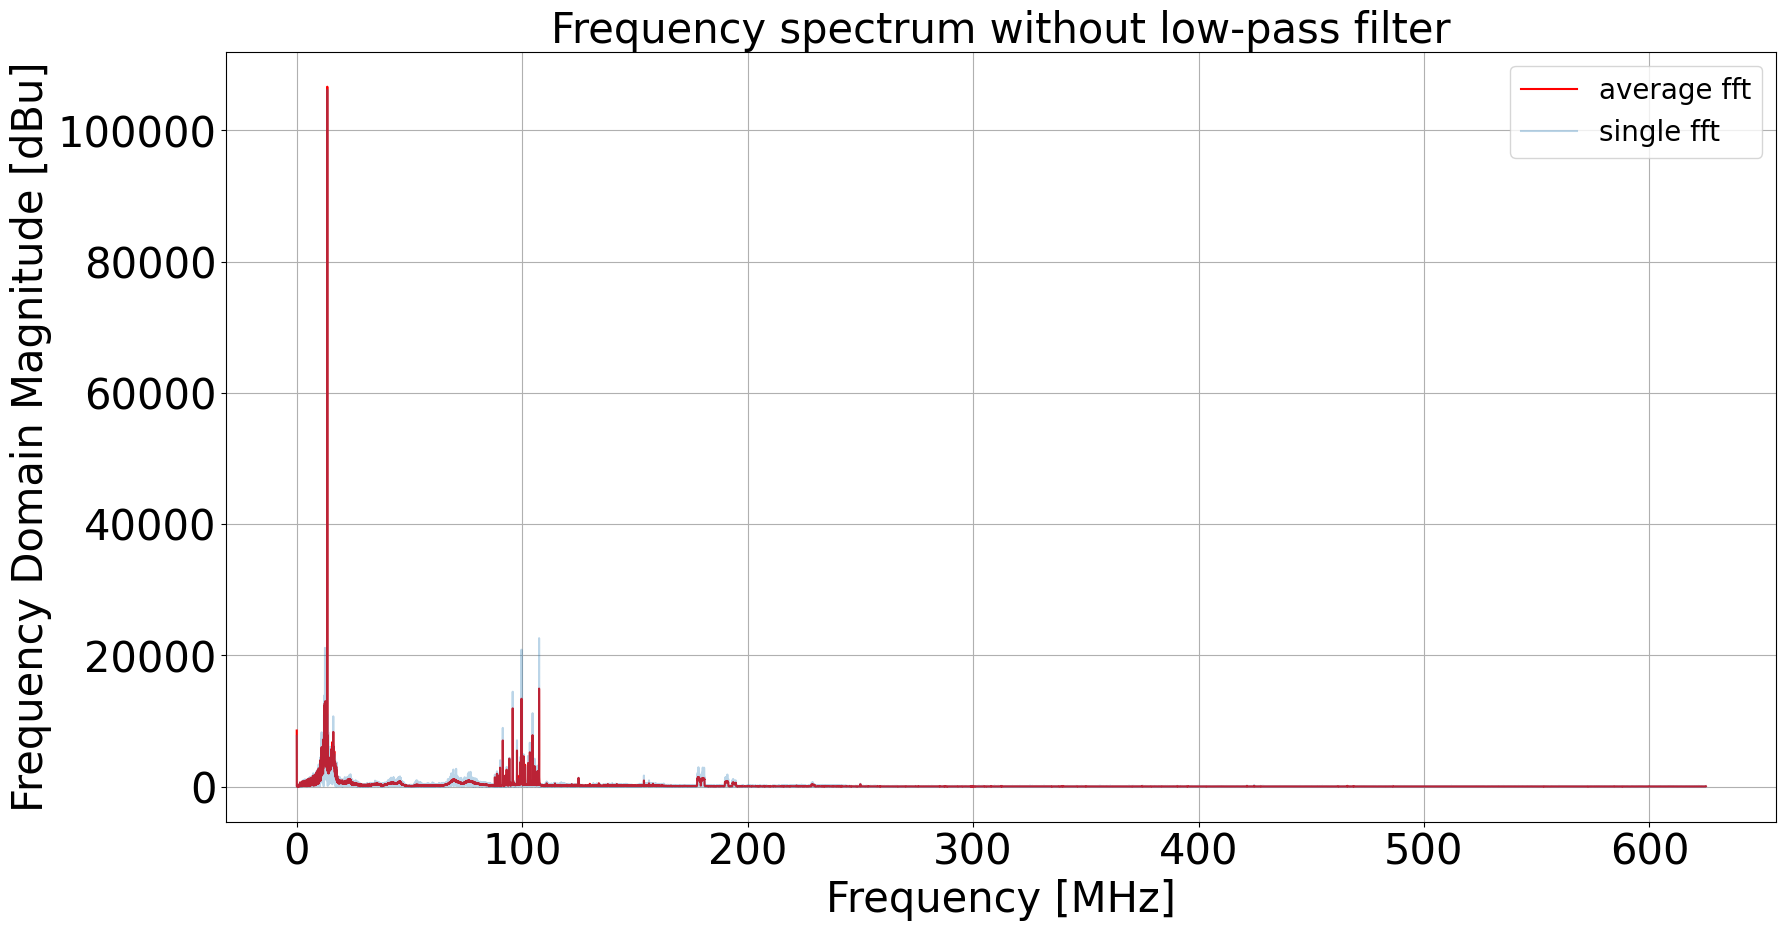

In [56]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_B, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_B, avg_fft_dBu_B, color = 'red', label = 'average fft')
plt.plot(freqs_B, Y_dBu_B, alpha = 0.3, label = 'single fft')
plt.title('Frequency spectrum without low-pass filter', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.legend(fontsize = 20)
#plt.semilogx()

#plt.savefig("080824_16.07/fft_wo_lowpass.png", format = "png", bbox_inches="tight")
#plt.savefig("080824_16.07/fft_wo_lowpass.pdf", format = "pdf", bbox_inches="tight")

plt.show()


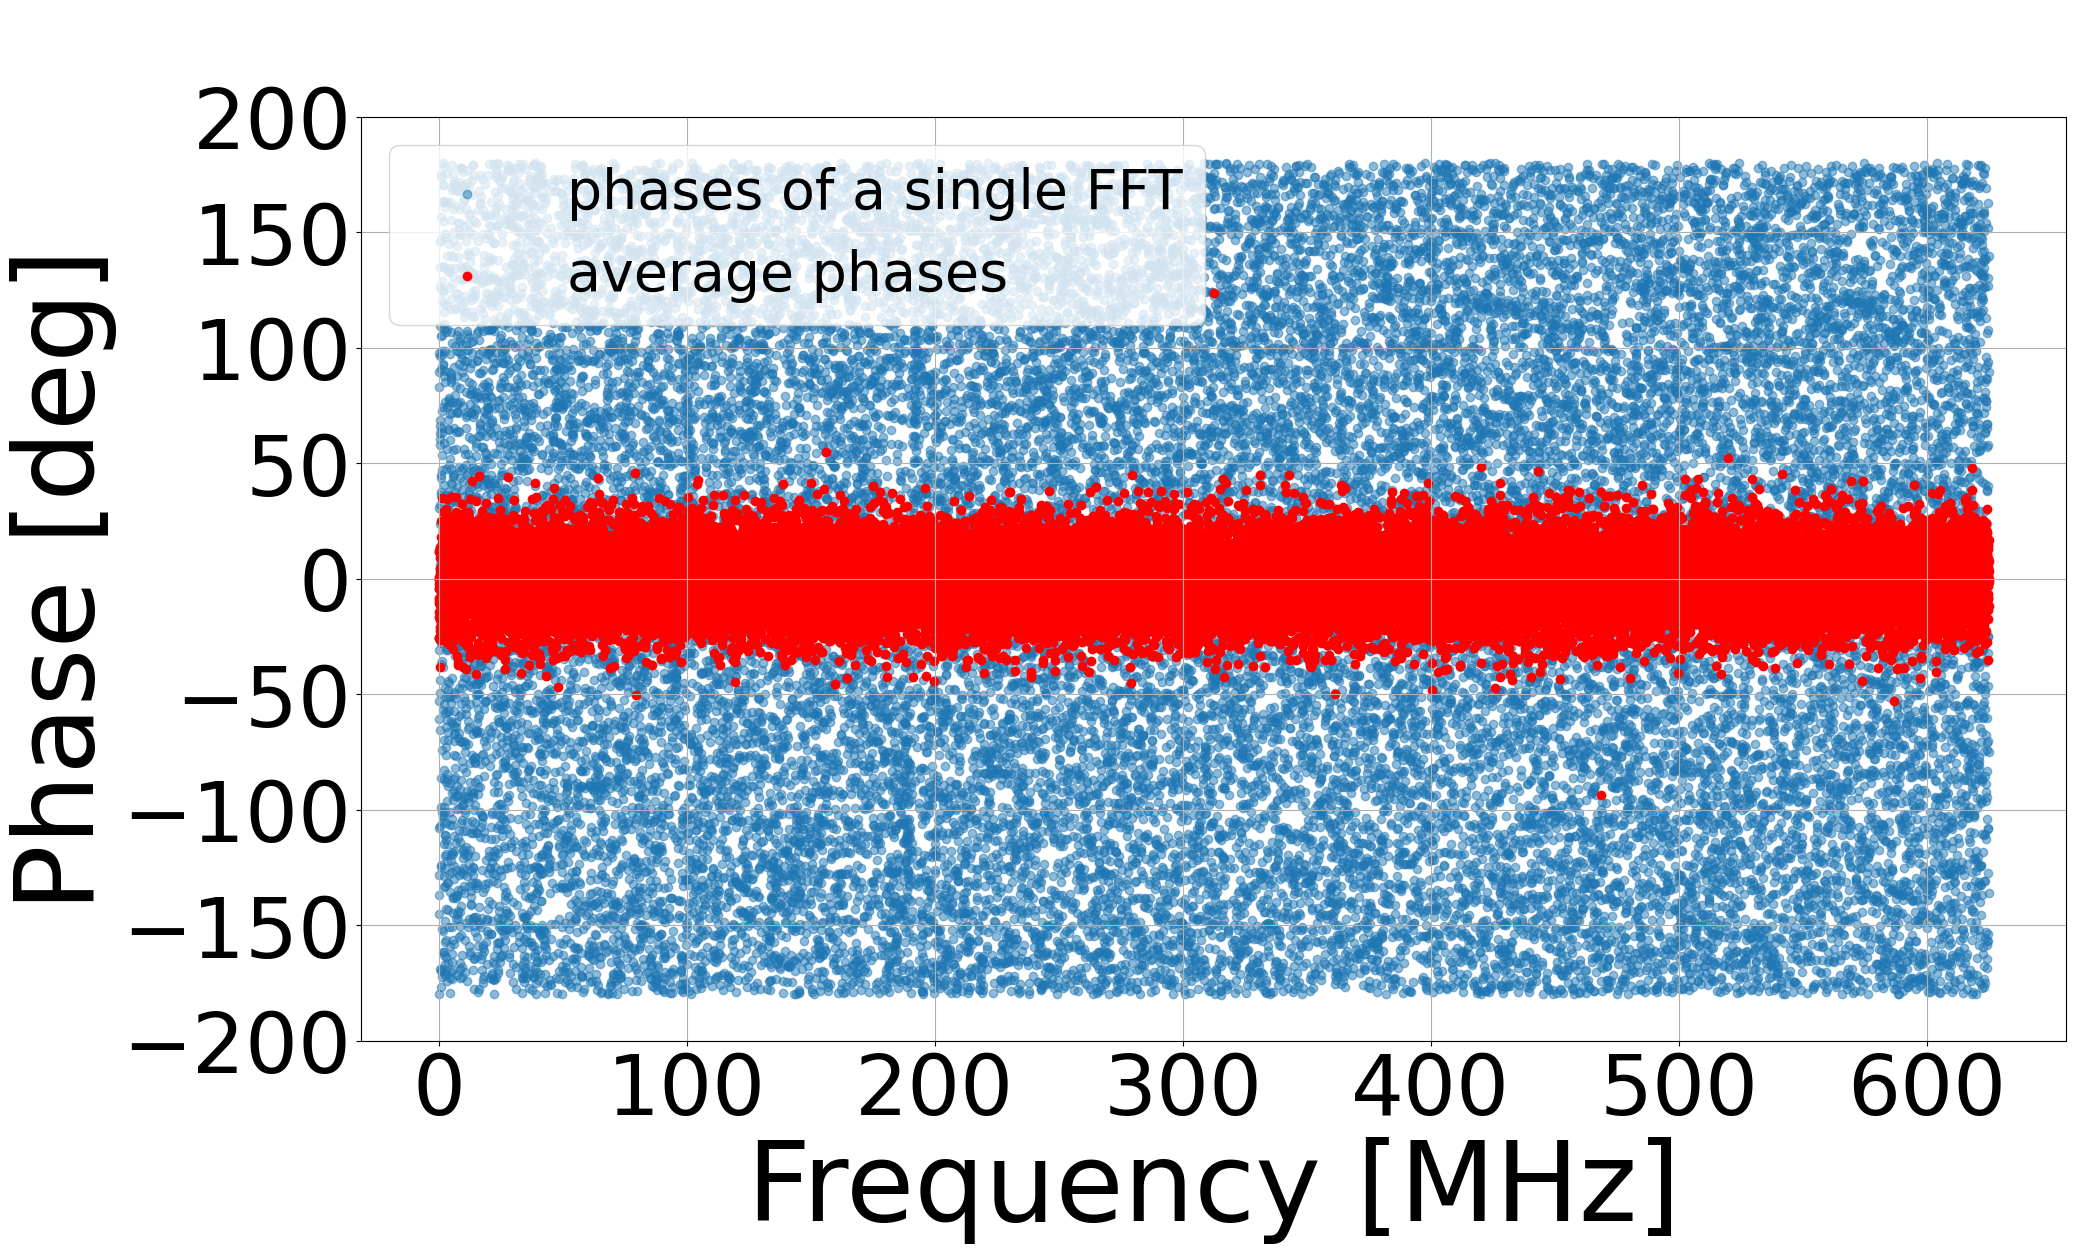

In [68]:
plt.figure(figsize=(22, 12))
#plt.errorbar(freqs_B, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_B, phase_B, alpha = 0.5, label = 'phases of a single FFT')
plt.scatter(freqs_B, avg_phases_B, color = 'red', label = 'average phases')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.legend(fontsize = 40, loc = 'best')
plt.ylim(-200, 200)

#plt.savefig("080824_14.24/avg_phases_B.png", format = "png", bbox_inches="tight")
plt.savefig("../../Results/080824_15.42/MethodB_avg_phases.pdf", format = "pdf", bbox_inches="tight")

plt.show()


# Comparison between the two methods

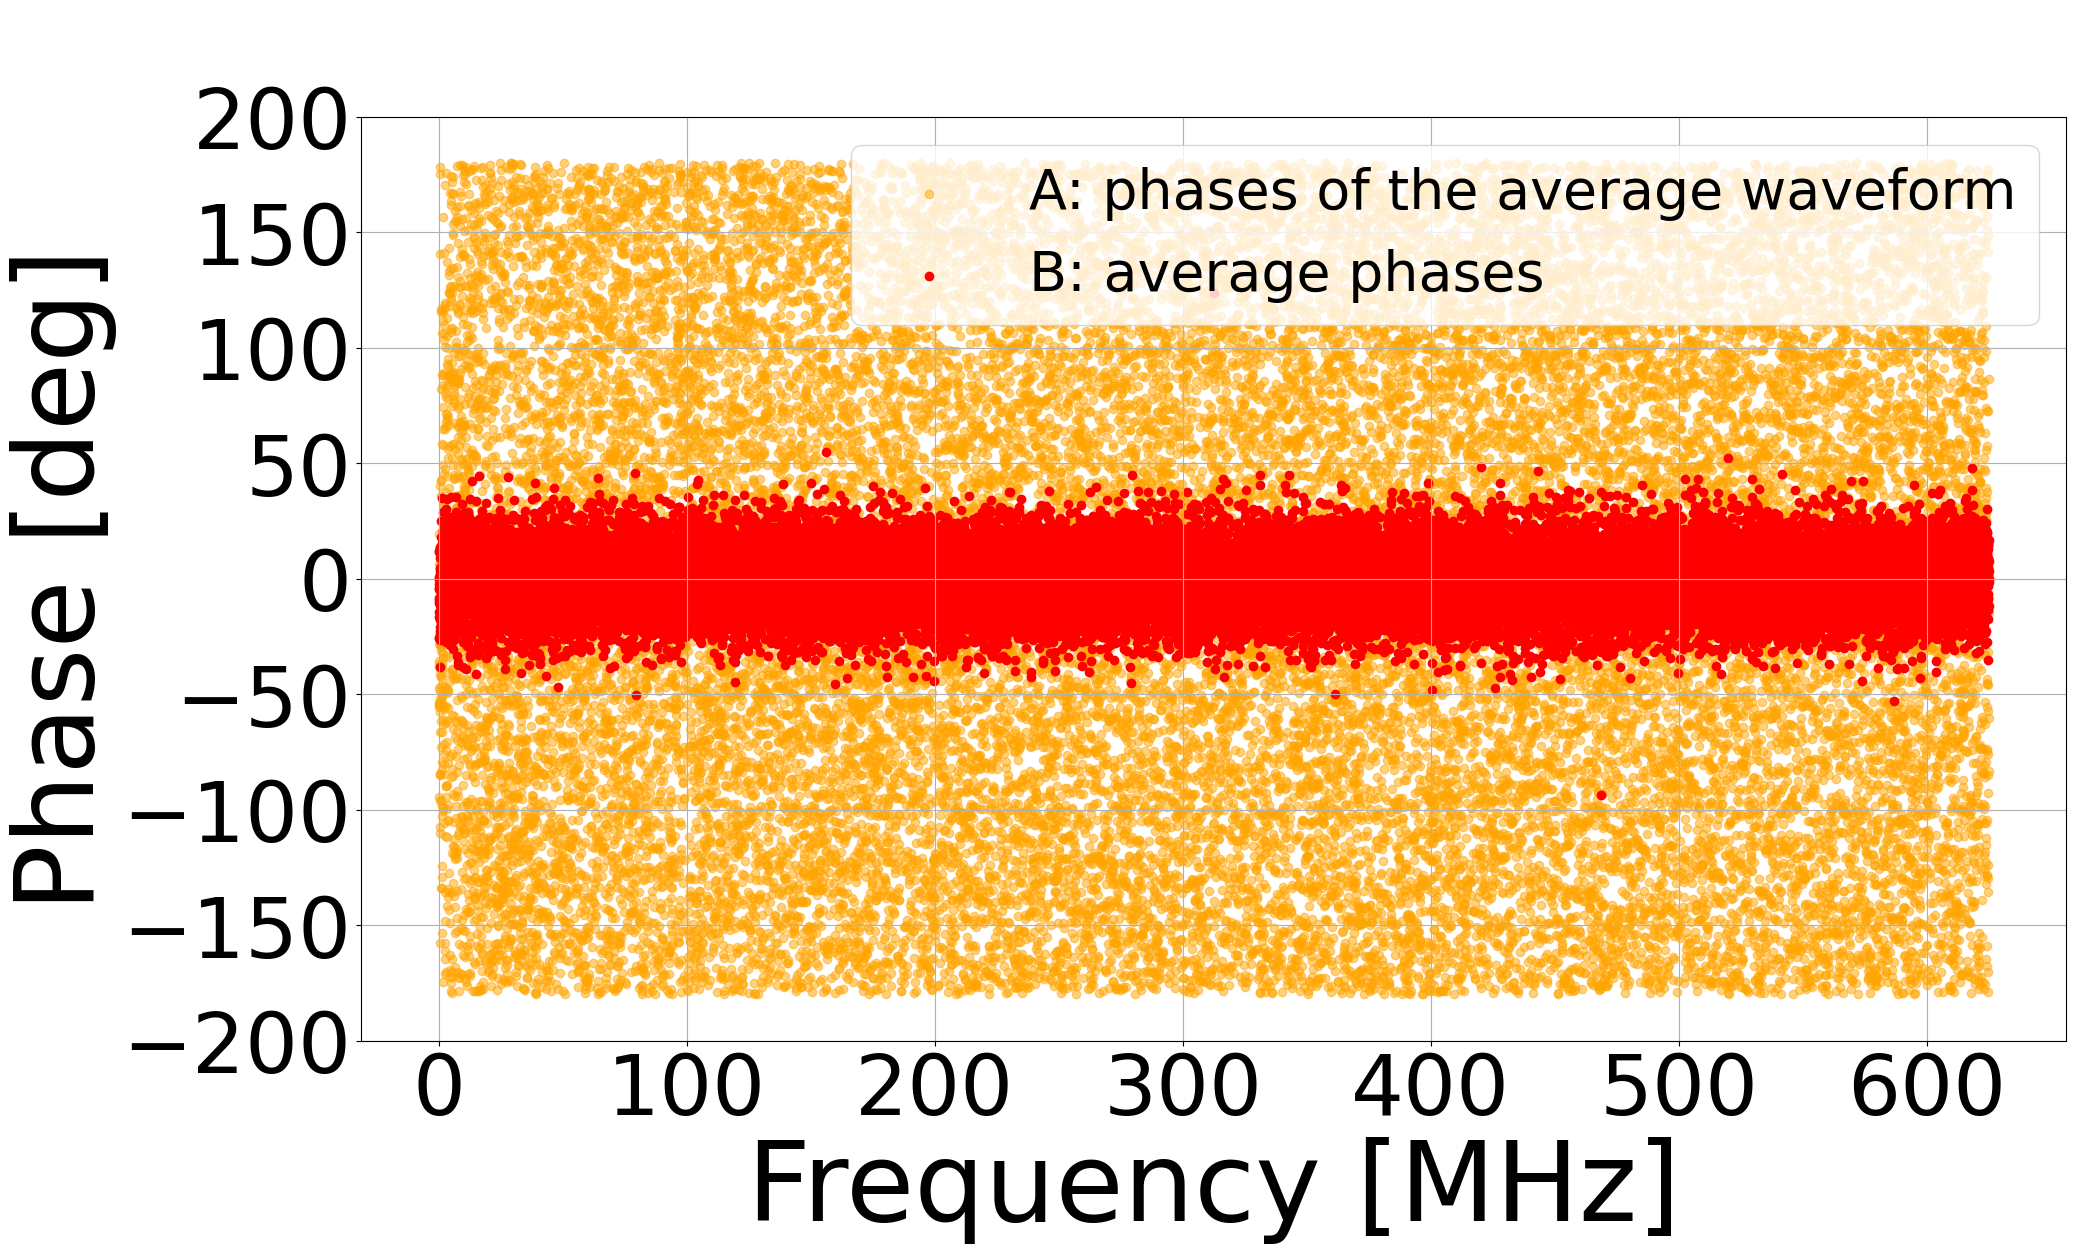

In [69]:
plt.figure(figsize=(22, 12))

#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_A, phases_A, alpha = 0.5, color = 'orange', label = 'A: phases of the average waveform')
plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [deg]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.ylim(-200, 200)
#plt.semilogx()

#---------------------------------------------------------------
#plt.errorbar(freqs, magnitudes_avg, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_B, avg_phases_B, color = 'red', label = 'B: average phases')

plt.legend(fontsize = 40, loc = 'best')
#plt.savefig("080824_14.24/A_VS_B_phases.png", format = "png", bbox_inches="tight")
plt.savefig("../../Results/080824_15.42/A_vs_B_phases.pdf", format = "pdf", bbox_inches="tight")

plt.show()